# Algoritmos de Classificação: Regressão Logística

Nós vamos utilizar o dataset Bank Marketing disponibilizado no [site da UCI](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing). Utilizaremos uma versão adaptada para os objetivos da aula e disponível na pasta `data`.

> The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the investment product would be or not subscribed.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report, roc_auc_score)

from plotting import (multiple_histograms_plot, plot_confusion_matrix, plot_roc)
from sklearn.externals import joblib

In [2]:
sns.set_context("notebook", font_scale=1.5)

In [3]:
df = pd.read_csv('../data/bank_marketing.csv')

Segue uma descrição sucinta de cada uma das colunas do dataset:

- `duration_seconds`: last contact duration, in seconds (numeric).

- `duration_minutes`: last contact duration, in minutes (numeric).

- `duration_hours`: last contact duration, in hours (numeric).

- `emp.var.rate`: employment variation rate - quarterly indicator (numeric)

- `nr.employed`: number of employees - quarterly indicator (numeric)

- `euribor3m`: euribor 3 month rate - daily indicator (numeric)

- `month`: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

- `contact`: contact communication type (1 for cellular, 2 for telephone) 

- `loan`: has personal loan? (0 for no, 1 for yes)

- `subscribed` - has the client subscribed a term deposit? (True, False)

## Preparando os dados

In [4]:
X = df.drop(columns=['month', 'subscribed'])
y = df['subscribed']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0)

## Aplicando a Regressão Logística

In [6]:
logreg = LogisticRegression()

In [7]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [8]:
y_pred[:5]

array([False, False, False, False, False], dtype=bool)

In [9]:
accuracy_test = accuracy_score(y_test, y_pred)
print(f'accuracy (test): {accuracy_test*100:.1f}%')

accuracy (test): 88.8%


## Avaliação do modelo

### Matriz de Confusão, Precisão, Recall

In [10]:
confusion_matrix(y_test, y_pred)

array([[7315,    0],
       [ 922,    0]])

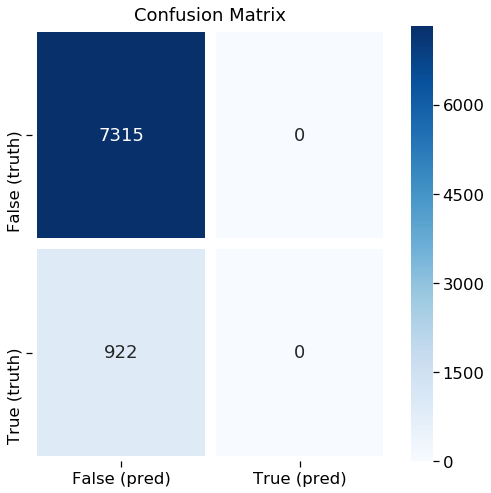

In [11]:
plot_confusion_matrix(y_test, y_pred)

In [12]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.89      1.00      0.94      7315
       True       0.00      0.00      0.00       922

avg / total       0.79      0.89      0.84      8237



/Users/gabrielcs/anaconda/envs/tera-2019-06/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Utilizando as probabilidades

In [13]:
y_pred_proba = logreg.predict_proba(X_test)
y_pred_proba[:5]

array([[ 0.95352896,  0.04647104],
       [ 0.95820907,  0.04179093],
       [ 0.77815062,  0.22184938],
       [ 0.95827664,  0.04172336],
       [ 0.77889741,  0.22110259]])

In [14]:
y_pred_proba = y_pred_proba[:, 1]
y_pred_proba[:5]

array([ 0.04647104,  0.04179093,  0.22184938,  0.04172336,  0.22110259])

In [15]:
def predictions_hist(y_pred_proba, y_test, density=True):
    preds_df = pd.DataFrame(data=[y_pred_proba, y_test.astype(str)],
                            index=['Prediction', 'True Value']).T

    preds_df['Prediction'] = preds_df['Prediction'].astype(float)
    preds_df['True Value'] = preds_df['True Value'].astype(str)

    multiple_histograms_plot(data=preds_df, x='Prediction', hue='True Value',
                             bins=np.arange(0, 1.1, 0.025), density=density, probability_hist=True)

    return preds_df

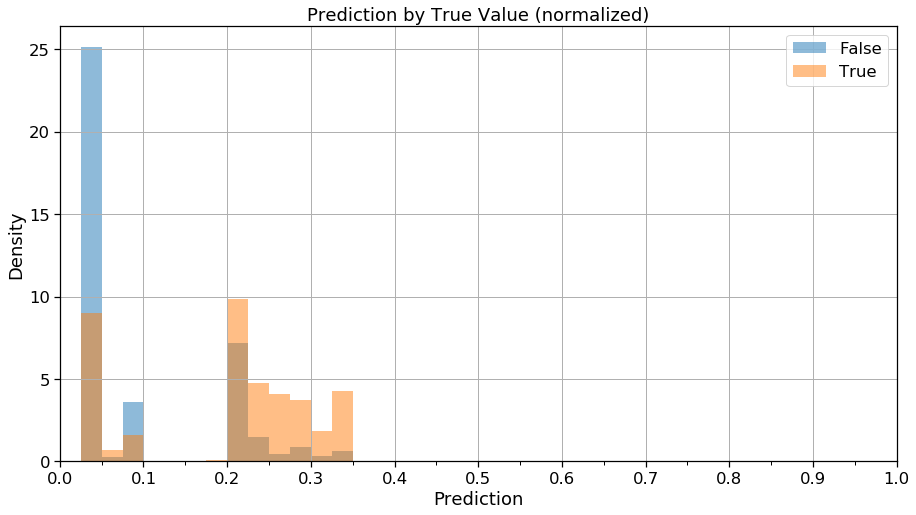

In [16]:
preds_df = predictions_hist(y_pred_proba, y_test)

In [17]:
preds_df.head()

,Prediction,True Value
0,0.046471,False
1,0.041791,False
2,0.221849,False
3,0.041723,False
4,0.221103,False


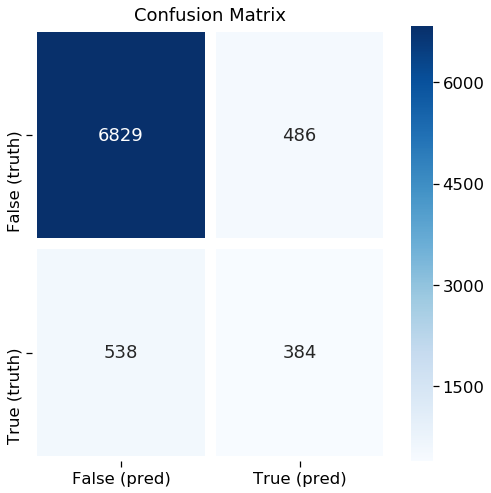

In [18]:
y_pred_customizado = y_pred_proba >= 0.23
plot_confusion_matrix(y_test, y_pred_customizado)

In [19]:
print(classification_report(y_test, y_pred_customizado))

             precision    recall  f1-score   support

      False       0.93      0.93      0.93      7315
       True       0.44      0.42      0.43       922

avg / total       0.87      0.88      0.87      8237



### Outras métricas populares

In [20]:
print(f'auc (test): {roc_auc_score(y_test, y_pred_proba):.4f}')

auc (test): 0.7692


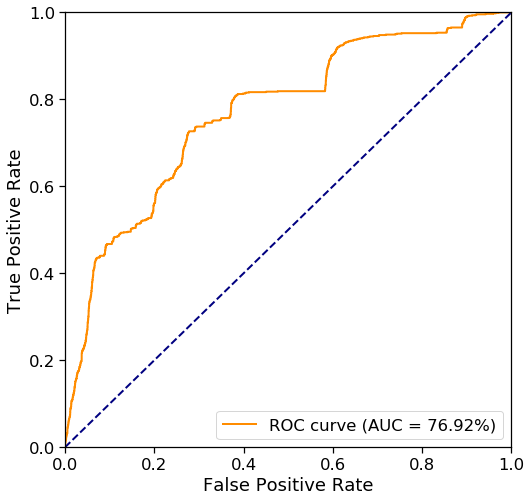

In [21]:
auc_test = plot_roc(y_test, y_pred_proba)

### Identificação de overfitting

In [22]:
y_pred_proba_train = logreg.predict_proba(X_train)[:, 1]

In [23]:
print(f'auc (train): {roc_auc_score(y_train, y_pred_proba_train):.4f}')
print(f'auc (test): {roc_auc_score(y_test, y_pred_proba):.4f}')

auc (train): 0.7628
auc (test): 0.7692


## Tentando melhorar o modelo

### Tratamento de outliers

In [24]:
df_no_outliers = df.copy()

In [25]:
outlier_candidates = df_no_outliers['duration_seconds'] > 3000
df_no_outliers[outlier_candidates]

,duration_seconds,duration_minutes,duration_hours,emp.var.rate,nr.employed,euribor3m,month,contact,loan,subscribed
2313,673200,11220.000000,187.000000,1.1,5191.0,4.856,may,1,0,False
4213,615600,10260.000000,171.000000,1.1,5191.0,4.858,may,1,0,False
6279,618800,10313.333333,171.888889,1.1,5191.0,4.857,may,1,0,True
7726,726200,12103.333333,201.722222,1.1,5191.0,4.864,may,1,0,True
12028,636600,10610.000000,176.833333,1.4,5228.1,4.955,jun,1,0,True
13819,728600,12143.333333,202.388889,1.4,5228.1,4.963,jul,2,0,True
19631,684400,11406.666667,190.111111,1.4,5228.1,4.968,aug,2,0,False
20995,664400,11073.333333,184.555556,1.4,5228.1,4.964,aug,2,1,False
22191,839800,13996.666667,233.277778,1.4,5228.1,4.963,aug,1,0,True
24002,650600,10843.333333,180.722222,-0.1,5195.8,5.045,oct,1,0,False


In [26]:
df_no_outliers.loc[outlier_candidates, 'duration_seconds'] = 3000
df_no_outliers.loc[outlier_candidates, 'duration_minutes'] = 3000 / 60
df_no_outliers.loc[outlier_candidates, 'duration_hours'] = 3000 / 60 / 60

In [27]:
df_no_outliers[outlier_candidates]

,duration_seconds,duration_minutes,duration_hours,emp.var.rate,nr.employed,euribor3m,month,contact,loan,subscribed
2313,3000,50.0,0.833333,1.1,5191.0,4.856,may,1,0,False
4213,3000,50.0,0.833333,1.1,5191.0,4.858,may,1,0,False
6279,3000,50.0,0.833333,1.1,5191.0,4.857,may,1,0,True
7726,3000,50.0,0.833333,1.1,5191.0,4.864,may,1,0,True
12028,3000,50.0,0.833333,1.4,5228.1,4.955,jun,1,0,True
13819,3000,50.0,0.833333,1.4,5228.1,4.963,jul,2,0,True
19631,3000,50.0,0.833333,1.4,5228.1,4.968,aug,2,0,False
20995,3000,50.0,0.833333,1.4,5228.1,4.964,aug,2,1,False
22191,3000,50.0,0.833333,1.4,5228.1,4.963,aug,1,0,True
24002,3000,50.0,0.833333,-0.1,5195.8,5.045,oct,1,0,False


In [28]:
X_no_outliers = df_no_outliers.drop(columns=['month', 'subscribed'])
y_no_outliers = df_no_outliers['subscribed']

(X_train_no_outliers, X_test_no_outliers, 
 y_train_no_outliers, y_test_no_outliers) = train_test_split(X_no_outliers, y_no_outliers, 
                                                             test_size=0.2, random_state=0)

In [29]:
logreg = LogisticRegression()
logreg.fit(X_train_no_outliers, y_train_no_outliers)
y_pred_proba_no_outliers = logreg.predict_proba(X_test_no_outliers)[:, 1]

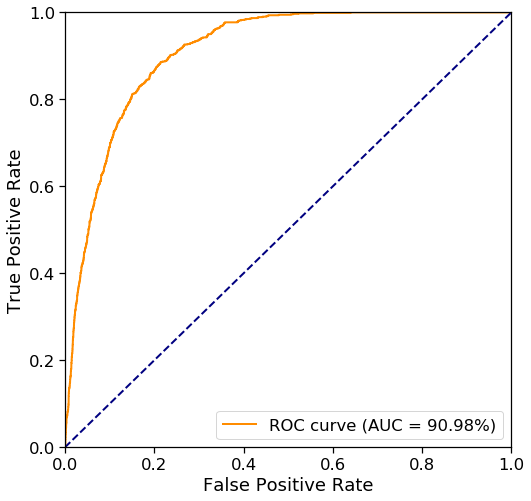

In [30]:
_ = plot_roc(y_test, y_pred_proba_no_outliers)

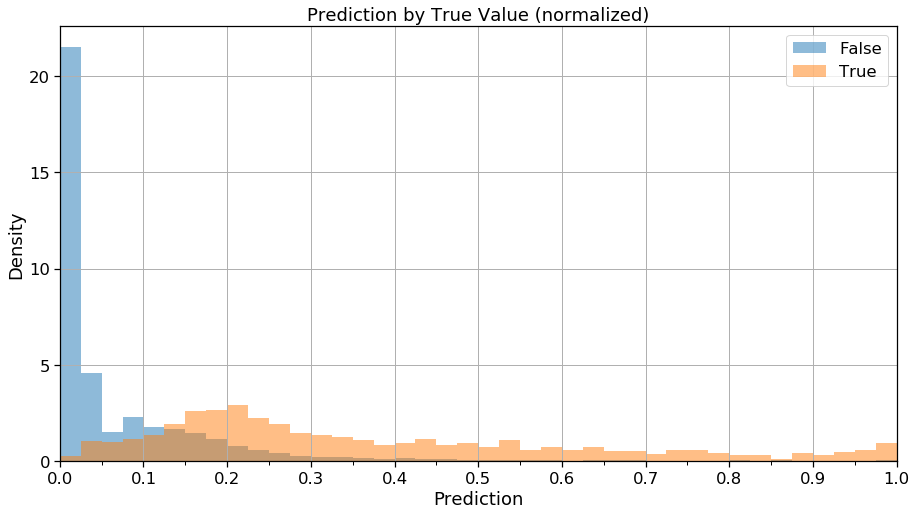

In [31]:
_ = predictions_hist(y_pred_proba_no_outliers, y_test_no_outliers)

In [32]:
def confusion_matrix_report(y_test, y_pred_proba, thres=0.5):
    y_pred_proba_customizado = y_pred_proba >= thres
    print(classification_report(y_test, y_pred_proba_customizado))
    plot_confusion_matrix(y_test_no_outliers, y_pred_proba_customizado)

             precision    recall  f1-score   support

      False       0.96      0.90      0.93      7315
       True       0.46      0.70      0.56       922

avg / total       0.90      0.88      0.89      8237



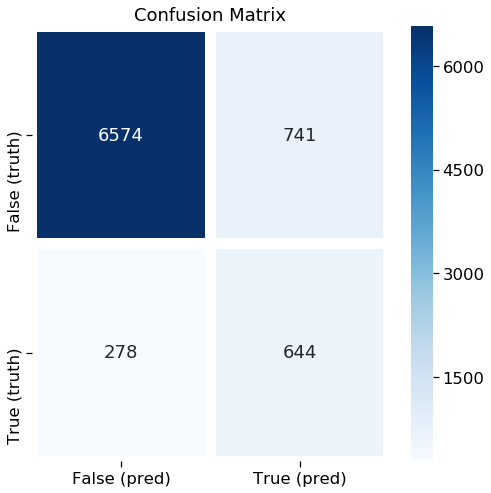

In [33]:
confusion_matrix_report(y_test_no_outliers, y_pred_proba_no_outliers, thres=0.2)

### Lidando com classes desbalanceadas (parâmetro `class_weight`)

In [34]:
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train_no_outliers, y_train_no_outliers)
y_pred_proba_class_weight = logreg.predict_proba(X_test_no_outliers)[:, 1]

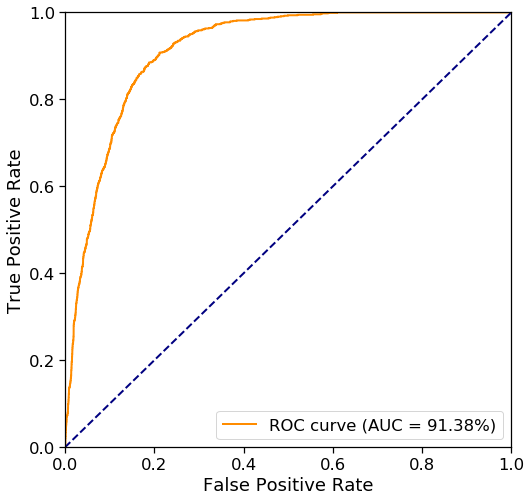

In [35]:
_ = plot_roc(y_test_no_outliers, y_pred_proba_class_weight)

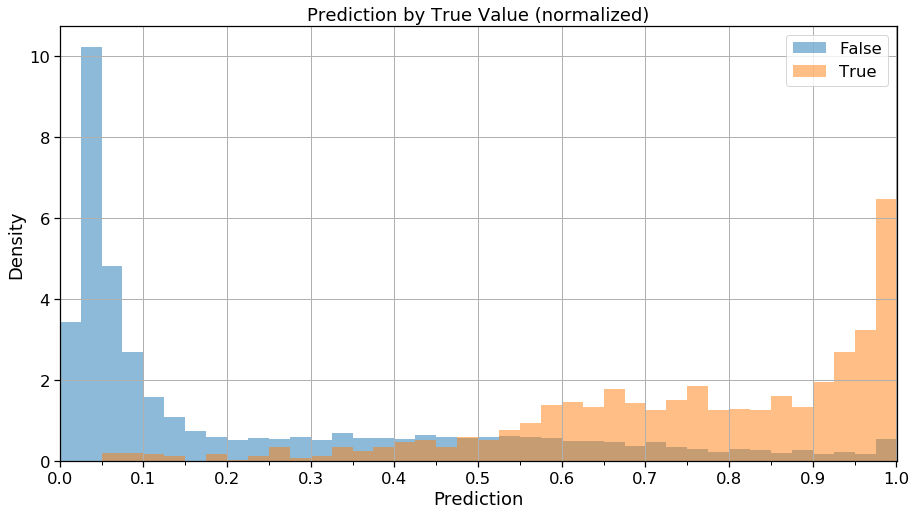

In [36]:
_ = predictions_hist(y_pred_proba_class_weight, y_test_no_outliers)

             precision    recall  f1-score   support

      False       0.96      0.89      0.92      7315
       True       0.45      0.72      0.56       922

avg / total       0.91      0.87      0.88      8237



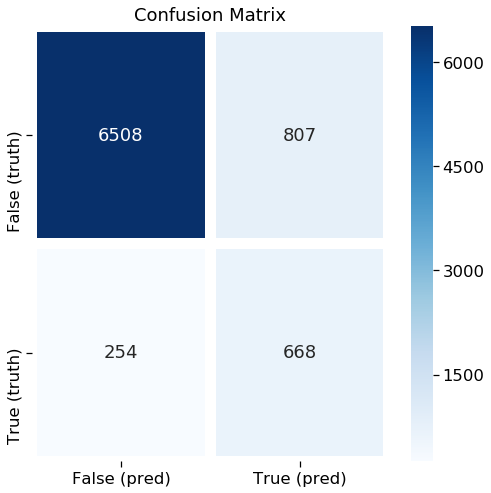

In [37]:
confusion_matrix_report(y_test_no_outliers, y_pred_proba_class_weight, thres=0.65)

### Padronização/normalização dos dados

In [38]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_no_outliers)

X_scaled = pd.DataFrame(scaled_data, 
                        index=X_no_outliers.index,
                        columns=X_no_outliers.columns)

df_standardized = pd.concat([X_scaled, y_no_outliers],
                            axis='columns')

In [39]:
df_standardized.head()

,duration_seconds,duration_minutes,duration_hours,emp.var.rate,nr.employed,euribor3m,contact,loan,subscribed
0,0.011203,0.011203,0.011203,0.64807,0.331657,0.712437,-1.318238,-0.461759,False
1,-0.424722,-0.424722,-0.424722,0.64807,0.331657,0.712437,-1.318238,-0.461759,False
2,-0.125023,-0.125023,-0.125023,0.64807,0.331657,0.712437,-1.318238,-0.461759,False
3,-0.416937,-0.416937,-0.416937,0.64807,0.331657,0.712437,-1.318238,-0.461759,False
4,0.190244,0.190244,0.190244,0.64807,0.331657,0.712437,-1.318238,2.165634,False


In [40]:
(X_train_standardized, X_test_standardized, 
 y_train_standardized, y_test_standardized) = train_test_split(X_scaled, y_no_outliers, 
                                                               test_size=0.2, random_state=0)

In [41]:
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train_standardized, y_train_standardized)
y_pred_proba_standardized = logreg.predict_proba(X_test_standardized)[:, 1]

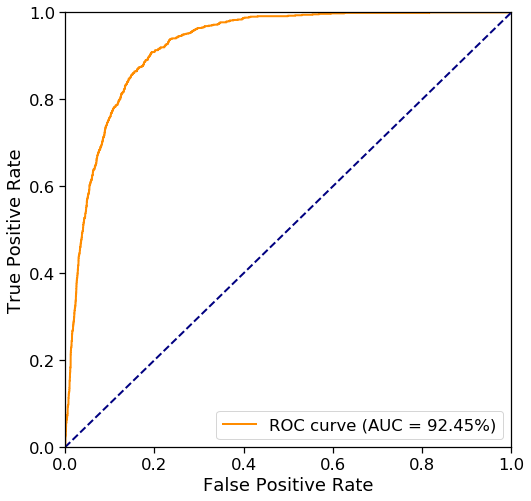

In [42]:
_ = plot_roc(y_test_no_outliers, y_pred_proba_standardized)

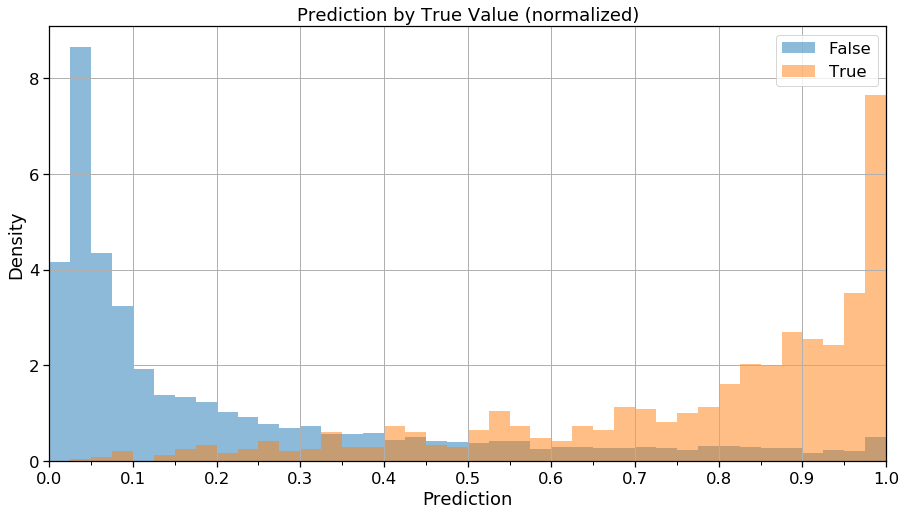

In [43]:
_ = predictions_hist(y_pred_proba_standardized, y_test_no_outliers)

             precision    recall  f1-score   support

      False       0.96      0.91      0.94      7315
       True       0.51      0.71      0.60       922

avg / total       0.91      0.89      0.90      8237



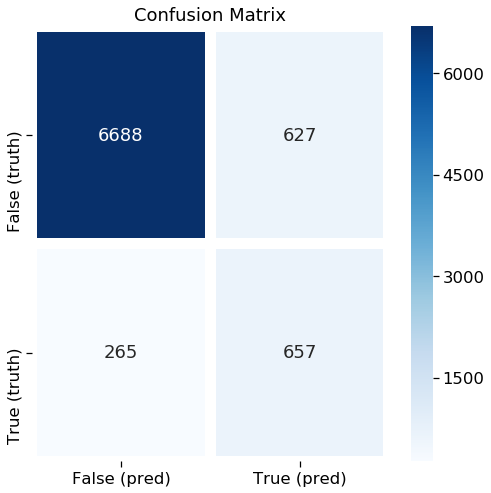

In [44]:
confusion_matrix_report(y_test_no_outliers, y_pred_proba_standardized, thres=0.7)

## Salvando o modelo

Vamos salvar o modelo para conseguirmos carregá-lo em análises futuras pós-aula. Para detalhes, veja a documentação do scikit-learn: [Model Persistence](http://scikit-learn.org/stable/modules/model_persistence.html).

In [45]:
_ = joblib.dump(logreg, '../models/logreg.pkl')

Vamos também salvar o dataset transformado, assim como foi utilizado pelo modelo final. Para facilitar a interpretação do modelo, salvaremos também uma versão para "display", que é sua versão antes da padronização dos dados.

In [46]:
df_standardized.to_csv('../data/bank_marketing_processed.csv', index=False)

In [47]:
(df_no_outliers.drop(columns='month')
               .to_csv('../data/bank_marketing_display.csv', index=False))